In [190]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.decomposition import PCA
from pyclustering.cluster.kmedians import kmedians
from sklearn.preprocessing import StandardScaler
plt.style.use('seaborn')
plt.style.use('dark_background')

# Loading the dataset

In [191]:
population = pd.read_csv('Weights/population.csv')
moreThan50k = pd.read_csv('Weights/more_than_50k.csv')

# Handling population.csv file

## 1. Preprocessing

In [192]:
# getting basic information about the data
population.head()

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AHSCOL,AMARITL,AMJIND,AMJOCC,...,PARENT,PEFNTVTY,PEMNTVTY,PENATVTY,PRCITSHP,SEOTR,VETQVA,VETYN,WKSWORK,YEAR
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94


In [193]:
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 40 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   AAGE      199523 non-null  int64 
 1   ACLSWKR   199523 non-null  object
 2   ADTIND    199523 non-null  int64 
 3   ADTOCC    199523 non-null  int64 
 4   AHGA      199523 non-null  object
 5   AHRSPAY   199523 non-null  int64 
 6   AHSCOL    199523 non-null  object
 7   AMARITL   199523 non-null  object
 8   AMJIND    199523 non-null  object
 9   AMJOCC    199523 non-null  object
 10  ARACE     199523 non-null  object
 11  AREORGN   199523 non-null  object
 12  ASEX      199523 non-null  object
 13  AUNMEM    199523 non-null  object
 14  AUNTYPE   199523 non-null  object
 15  AWKSTAT   199523 non-null  object
 16  CAPGAIN   199523 non-null  int64 
 17  CAPLOSS   199523 non-null  int64 
 18  DIVVAL    199523 non-null  int64 
 19  FILESTAT  199523 non-null  object
 20  GRINREG   199523 non-null 

In [194]:
population.describe()

,AAGE,ADTIND,ADTOCC,AHRSPAY,CAPGAIN,CAPLOSS,DIVVAL,NOEMP,SEOTR,VETYN,WKSWORK,YEAR
count,199523.000000,199523.000000,199523.000000,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,15.352320,11.306556,55.426908,434.71899,37.313788,197.529533,1.956180,0.175438,1.514833,23.174897,94.499672
std,22.310895,18.067129,14.454204,274.896454,4697.53128,271.896428,1984.163658,2.365126,0.553694,0.851473,24.411488,0.500001
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.000000
25%,15.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,94.000000
50%,33.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,2.000000,8.000000,94.000000
75%,50.000000,33.000000,26.000000,0.000000,0.00000,0.000000,0.000000,4.000000,0.000000,2.000000,52.000000,95.000000
max,90.000000,51.000000,46.000000,9999.000000,99999.00000,4608.000000,99999.000000,6.000000,2.000000,2.000000,52.000000,95.000000


### 1.1 Replacing missing data with NaN

In [195]:
# the string data has leading and trailing spaces which needs to be removed
for i in population.columns:
    if population[i].dtype != 'int64':
        population[i] = population[i].str.strip()

In [196]:
# replacing the missing values with nan value
population = population.replace('?', np.NaN)

### 1.2 Removing columns where more than 40% of the values are missing

In [197]:
# this will create a list of all the cols which have more than 40% values as nan
columns = []
percentageOfNan = []
colsToRemove = []
for i in population.columns:
    columns.append(i)
    percentageOfNan.append(population[i].isnull().sum()*100/population.shape[0])
    if percentageOfNan[-1] > 40:
        colsToRemove.append(i)

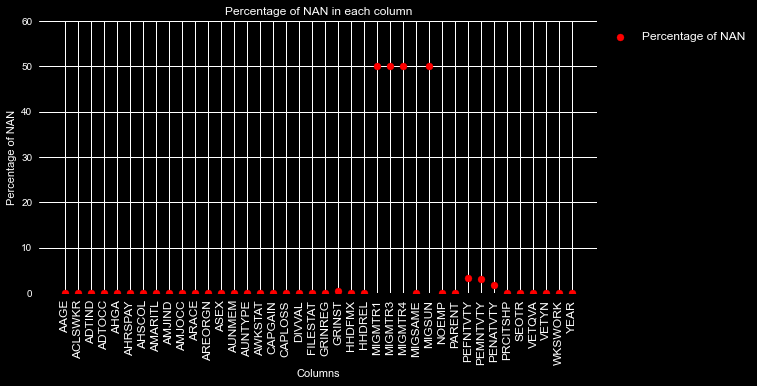

In [198]:
# visualising the columns which have more than 40% nan values
plt.figure(figsize=(10, 5))
plt.scatter(columns, percentageOfNan, color='red',marker='o', label='Percentage of NAN')
plt.xticks(rotation=90, fontsize=12)
plt.ylim(0, 60, 10)
plt.xlabel('Columns')
plt.ylabel('Percentage of NAN')
plt.title('Percentage of NAN in each column')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
plt.savefig('plots/percentage_of_nan.png')
plt.show()

In [199]:
# removing the columns which have more than 40% nan values
preprocessedPopulation = population.drop(colsToRemove, axis=1)

## 2. Feature Analysis

### 2.1 Histogram of values of each feature

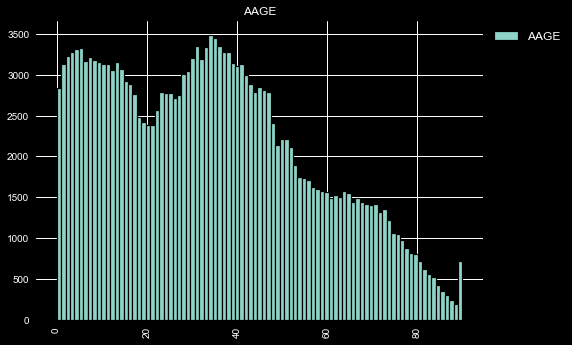

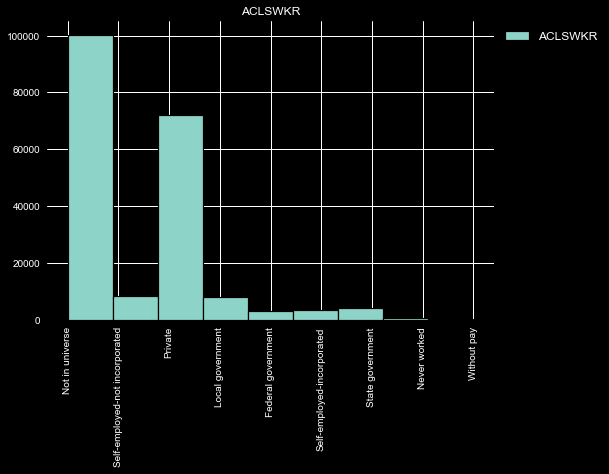

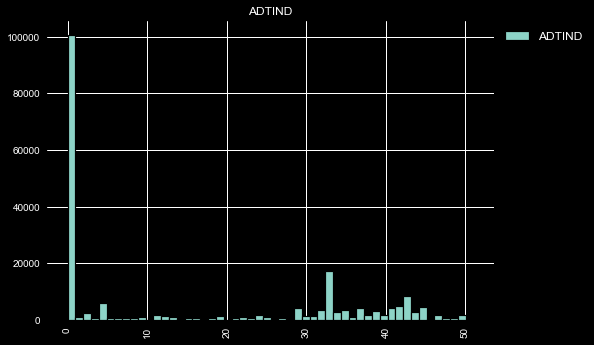

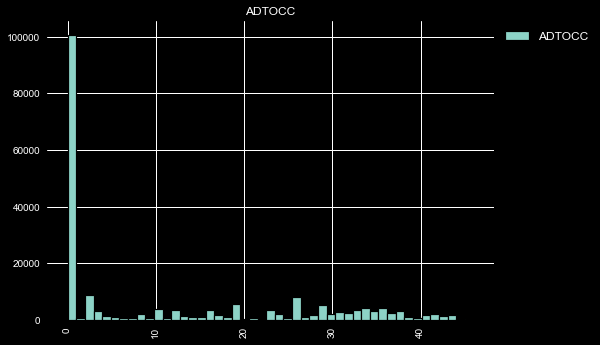

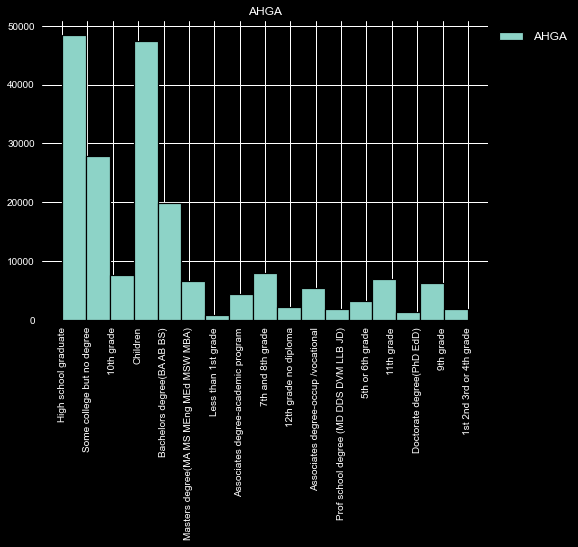

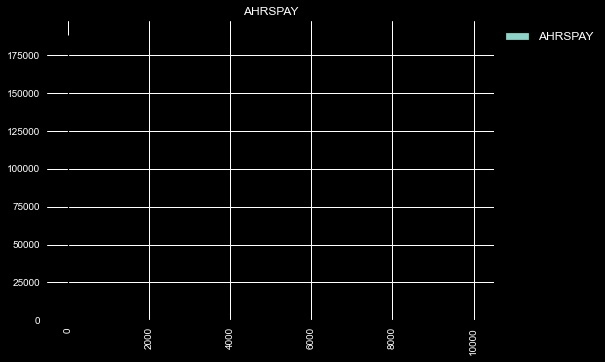

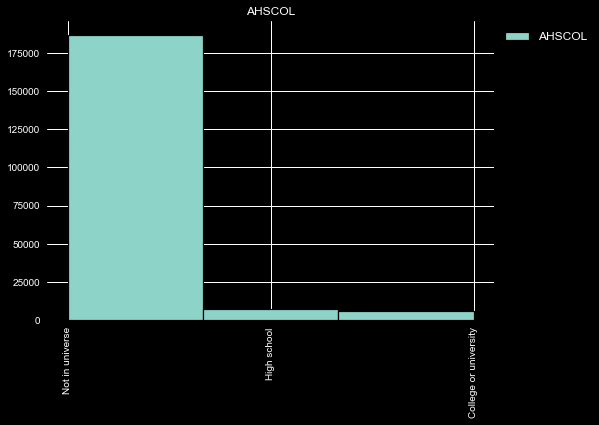

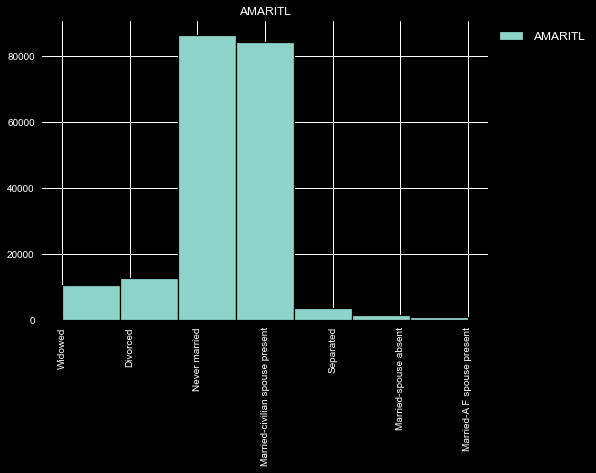

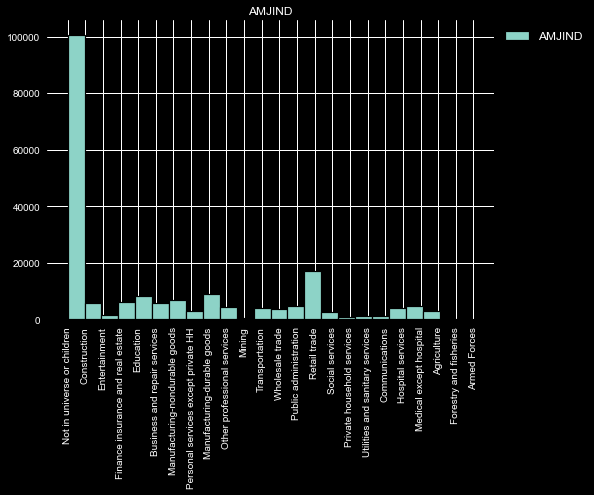

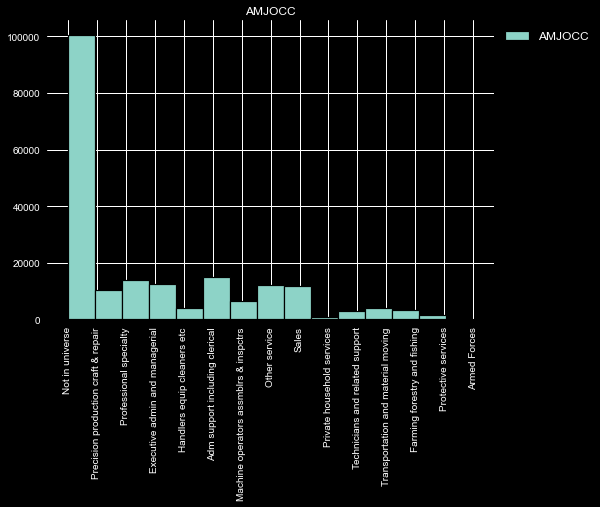

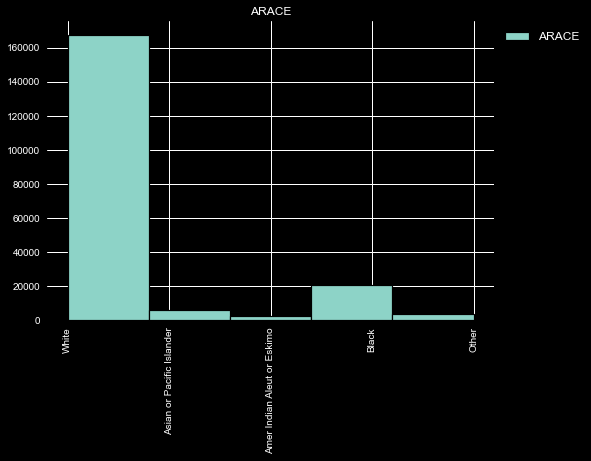

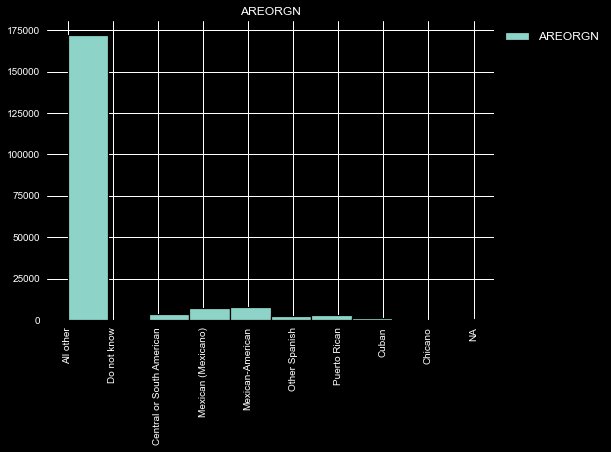

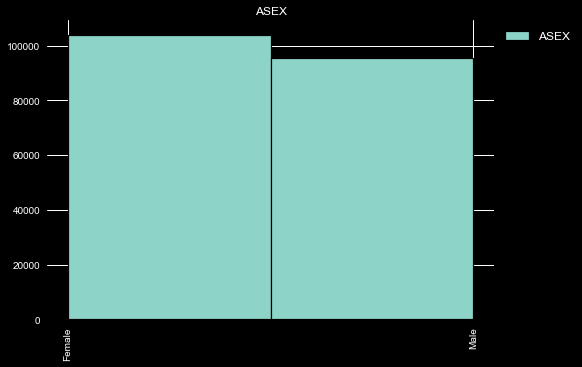

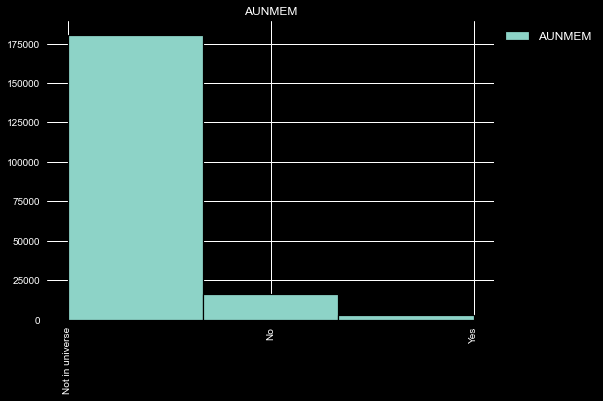

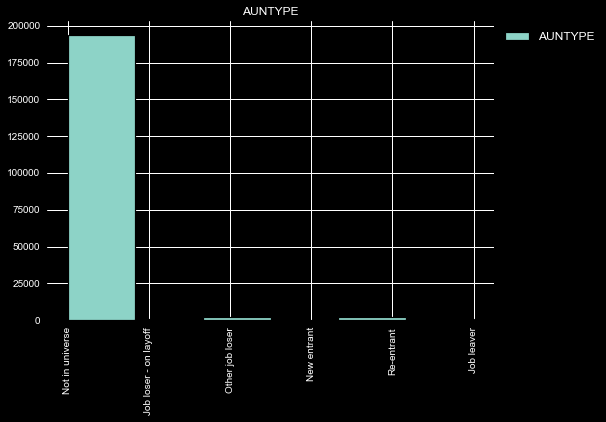

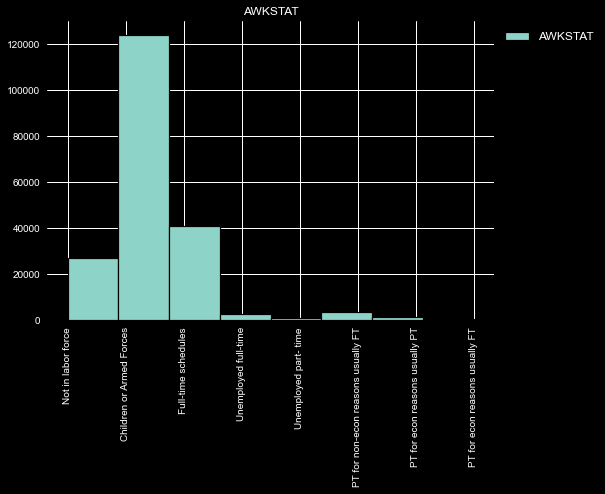

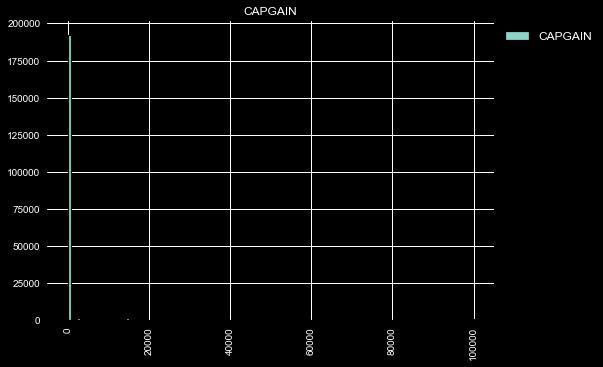

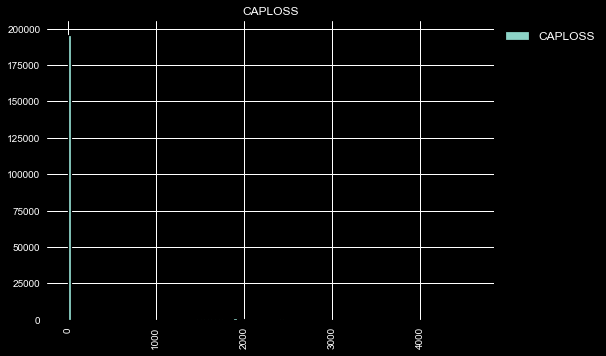

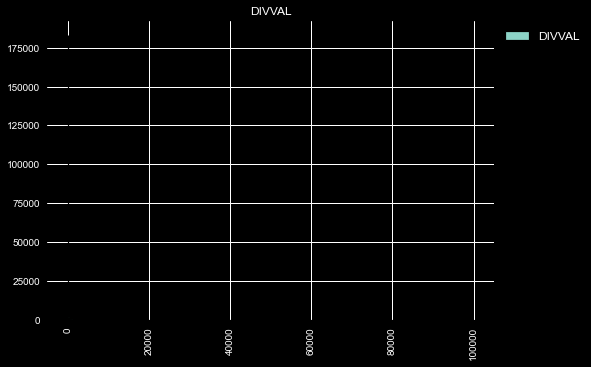

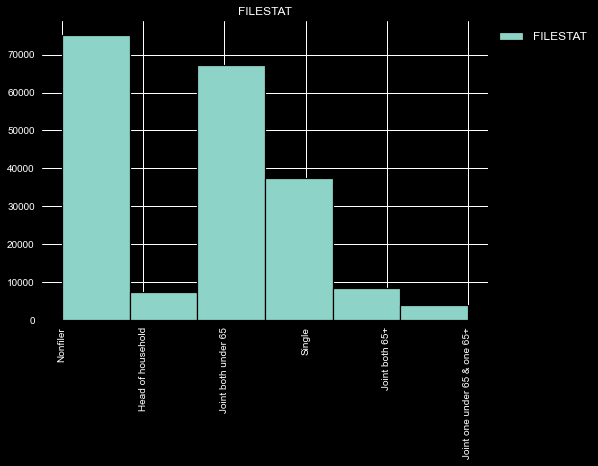

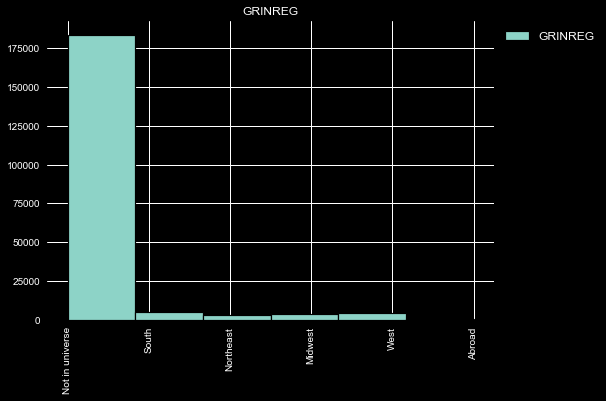

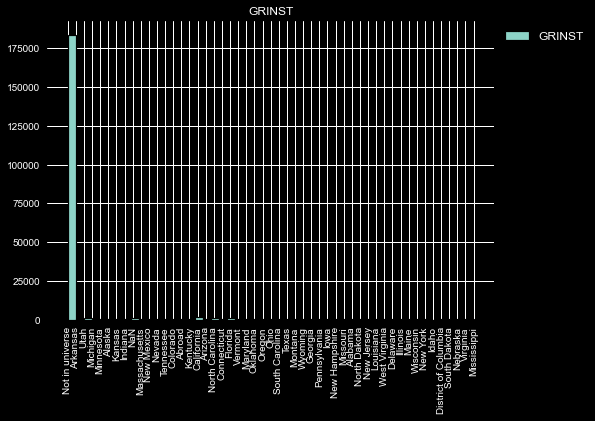

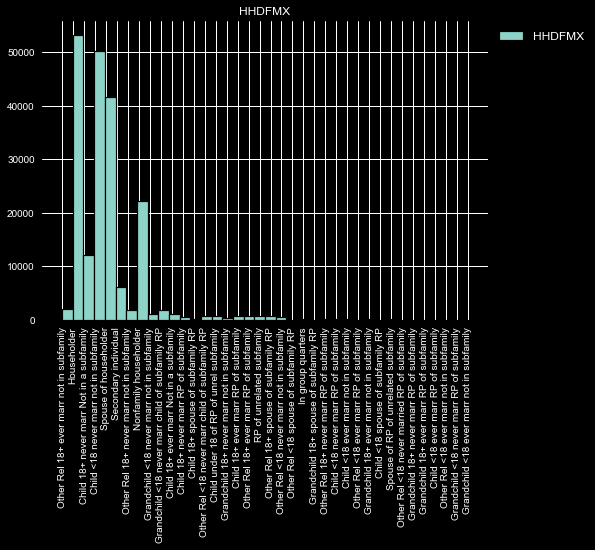

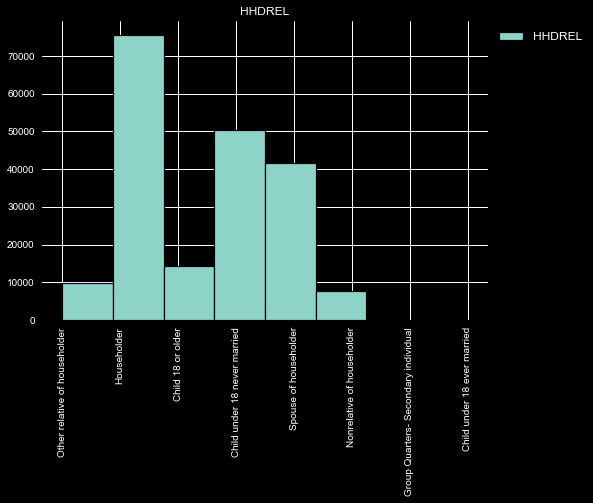

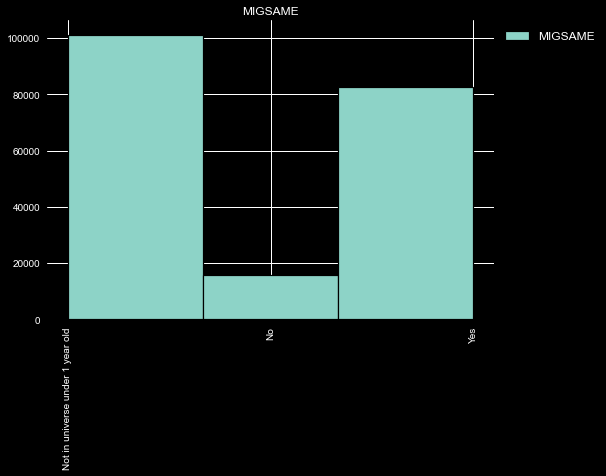

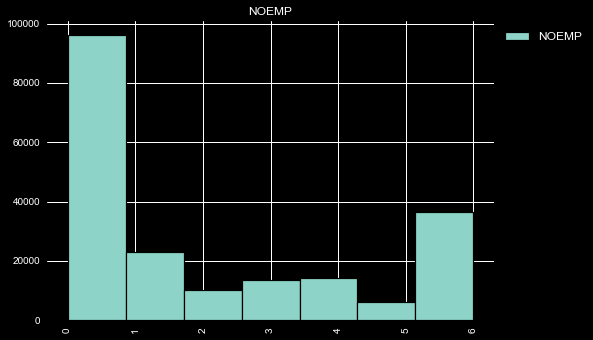

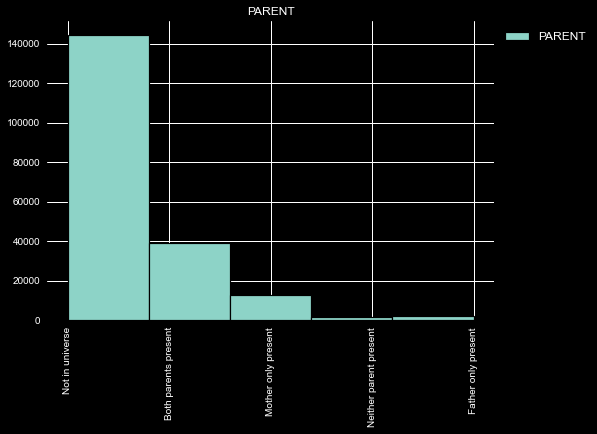

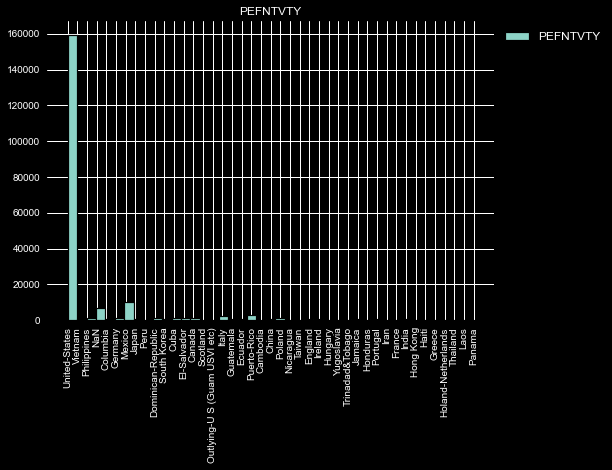

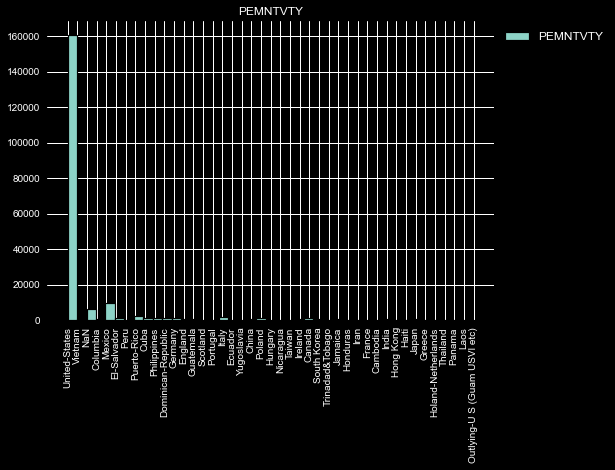

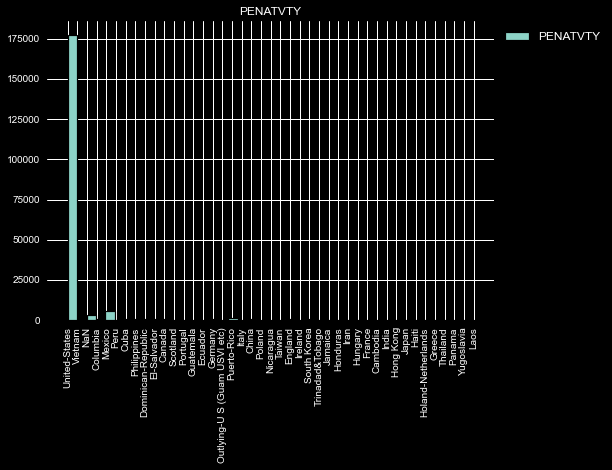

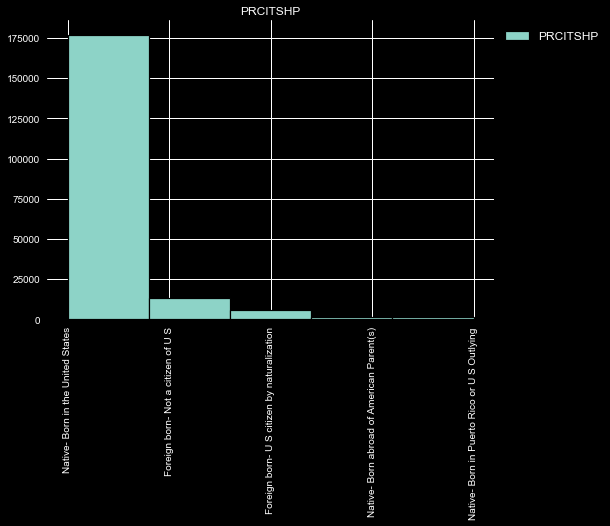

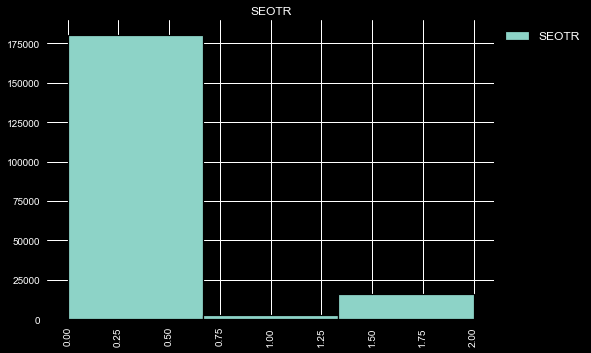

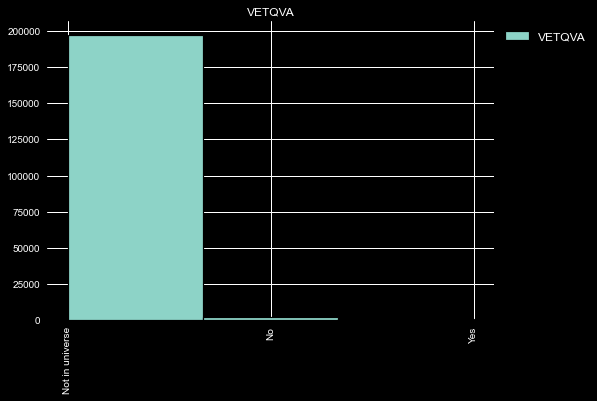

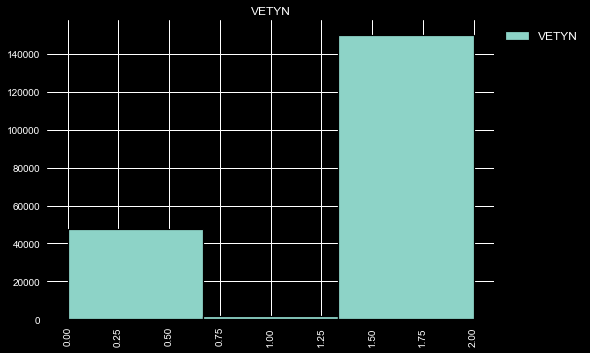

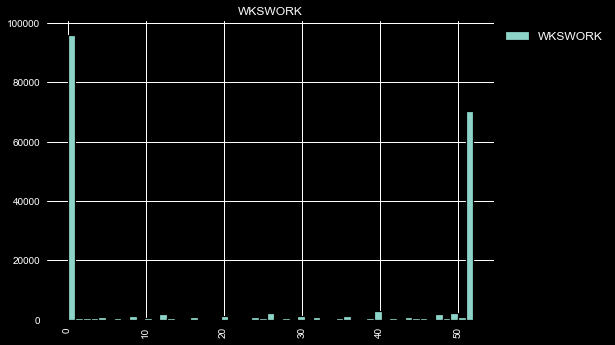

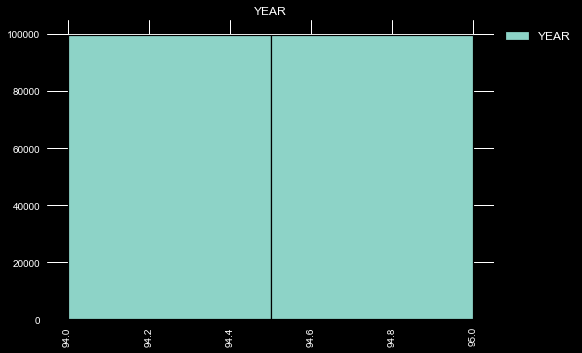

In [200]:
# code to plot the histograms of each feature of the dataset
for j in range(len(preprocessedPopulation.columns)):
    i = preprocessedPopulation.columns[j]
    plt.hist(preprocessedPopulation[i].replace(np.NaN, 'NaN'), bins=len(
        preprocessedPopulation[i].unique()), label=i, edgecolor='black', linewidth=1.2, histtype='barstacked')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
    plt.xticks(rotation=90, fontsize=10)
    plt.title(i)
    plt.savefig('plots/histogram_populationData_'+i+'.png')
    plt.show()

We can observe in the histograms plotted above that in various features, one value strongly dominates the other. This is a sign of a feature that is not useful for our analysis. We can thus remove those features from our dataset. One example of this is the feature GRINST.

To do so, I have removed all those features in which the differece between the most populous column and the second most populous coulumn exceeds 70% of the total values in the feature.

In [201]:
# finding the features to be removed from the dataset based on the above explanation
imbalancedCols = []
for i in tqdm(range(len(preprocessedPopulation.columns))):
    col = preprocessedPopulation.columns[i]
    valCounts = list(
        preprocessedPopulation[col].value_counts().sort_values(ascending=False))
    if len(valCounts) == 1:
        imbalancedCols.append(col)
    elif valCounts[0] - valCounts[1] > 0.7*np.sum(valCounts):
        imbalancedCols.append(col)

100%|██████████| 36/36 [00:00<00:00, 45.39it/s]


In [202]:
# removing the selected columns from the dataset
preprocessedPopulation.drop(imbalancedCols, axis=1, inplace=True)

At this stage, we have 19 final columns left in the dataset which we would deal with in the question

## 3. Imputation, Bucketization and One Hot Encoding

### 3.1 Replacing missing data with mode

In [203]:
# creating a dictionary for the modes of the categorical features which would be used in the lateer parts
globalModeDict = {}

In [204]:
# finding the mode for each feature in the dataframe
for i in preprocessedPopulation.columns:
    globalModeDict[i] = preprocessedPopulation[i].mode()[0]

In [205]:
# replacing the nan values with the mode of the respective categorical features
for i in preprocessedPopulation.columns:
    preprocessedPopulation[i] = preprocessedPopulation[i].replace(
        np.NaN, globalModeDict[i])

### 3.2 Bucketization of the data

In [206]:
# creating a dictionary for the final buckets of the data after bucketization which will be used in the later parts
finalBuckets = {}

In [207]:
# dividing the integer data, which have more than 6 unique values into 5 buckets which are equally spaced
for i in preprocessedPopulation.columns:
    if preprocessedPopulation[i].dtype == 'int64' and len(preprocessedPopulation[i].unique()) > 6:
        finalbins = np.linspace(
            preprocessedPopulation[i].min(), preprocessedPopulation[i].max(), 6)
        finalBuckets[i] = finalbins
        finalLabels = []
        for j in range(0, len(finalbins)-1):
            finalLabels.append(
                str(int(finalbins[j])) + '-' + str(int(finalbins[j+1])))
        preprocessedPopulation[i] = pd.cut(
            preprocessedPopulation[i], bins=finalbins, labels=finalLabels)

### 3.3 One Hot Encoding All the Features

In [208]:
# creating the dataframe with the one hot encoded categorical features
finalPopulationData = pd.DataFrame()

In [209]:
# one hot encoding all the data and adding each of the new feature in the final dataframe
for itr in tqdm(range(len(preprocessedPopulation.columns))):
    i = preprocessedPopulation.columns[itr]
    ohtVector = pd.get_dummies(
        preprocessedPopulation[i], sparse=True, drop_first=False)
    for j in ohtVector.columns:
        finalPopulationData[str(i) + '_' + str(j)] = ohtVector[j]

100%|██████████| 19/19 [00:03<00:00,  5.98it/s]


At this stage, our dataset has 172 columns which are one hot encoded

### 3.4 Feature Transformation

In [210]:
tempArr = np.array(finalPopulationData.copy())

#### 3.4.1 Fitting PCA and analysizing the cumulative variance

In [211]:
# creating a PCA instance and fitting it to the data
pca = PCA()
pca.fit(tempArr)

PCA()

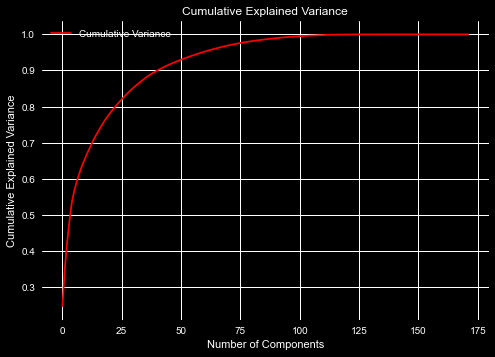

In [212]:
# Analysing the cumulative variance of the data
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='red', label='Cumulative Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.legend()
plt.savefig('plots/cumulative_explained_variance.png')
plt.show()

#### 3.4.2 Making decision on the number of principal components to be used
Looking at the above graph it is evident that the slope of cumulative variance decreases with the number of principal components. We can thus decide to use only the first 35 principal components which capture about 90% of the total variance.

#### 3.4.3 Applying PCA on top 35 components

In [213]:
model = PCA(n_components=35).fit(tempArr)

In [214]:
# finding the top 35 features
n_pcs = model.components_.shape[0]
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]
initial_columns = finalPopulationData.columns
most_important_names = [
    initial_columns[most_important[i]] for i in range(n_pcs)]
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}
df = pd.DataFrame(dic.items())
pcaCols = df[1].values

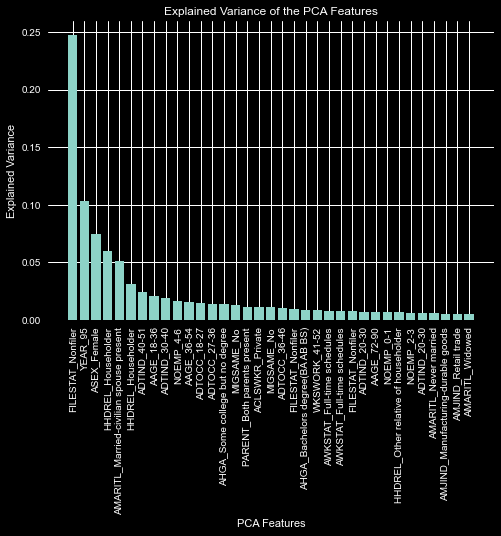

In [215]:
# Analyzing the top 35 features
plt.bar(range(len(pcaCols)), model.explained_variance_ratio_)
plt.xticks(range(len(pcaCols)), pcaCols, rotation=90)
plt.xlabel('PCA Features')
plt.ylabel('Explained Variance')
plt.title('Explained Variance of the PCA Features')
plt.savefig('plots/explained_variance_of_pca_features_35cols.png')
plt.show()

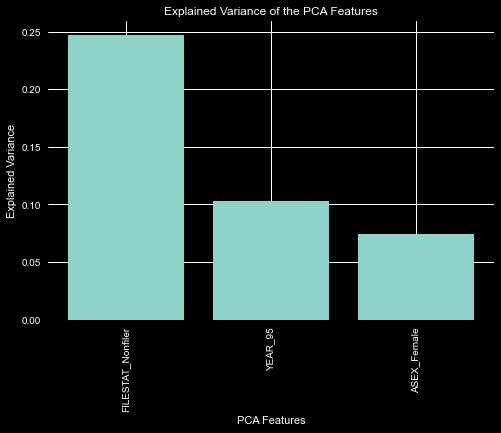

In [216]:
# Analyzing the top 3 features
plt.bar(range(len(pcaCols[:3])), model.explained_variance_ratio_[:3])
plt.xticks(range(len(pcaCols[:3])), pcaCols[:3], rotation=90)
plt.xlabel('PCA Features')
plt.ylabel('Explained Variance')
plt.title('Explained Variance of the PCA Features')
plt.savefig('plots/explained_variance_of_pca_features_3cols.png')
plt.show()

In [228]:
# converting the final data to be used for clustering in a dataframe
finalData = pd.DataFrame(model.transform(tempArr), columns=pcaCols)

At this stage the final data has 35 features.

## 4. Clustering

### Applying K-Medians Clustering

Making some helper functions

In [229]:
def get_distance(x, y):
    '''
    This function calculates the euclidean distance between two points
    param x: the first point
    param y: the second point
    return: the euclidean distance between the two points
    '''
    return np.sqrt(np.sum((x - y) ** 2))

In [230]:
def getAvgDist(clusters, medians, dataPts):
    '''
    This function calculates the average distance between the points and the median in the clusters
    param clusters: the clusters
    param medians: the medians of the clusters
    param dataPts: the data points
    return: the average distance between the points and the median in the clusters
    '''
    dist = []
    for i in range(len(clusters)):
        for j in range(len(clusters[i])):
            dist.append(get_distance(dataPts[clusters[i][j]], medians[i]))
    return np.mean(dist)

### 4.1 K-Medians Clustering for k in range [10, 24]

In [231]:
# normalizing the data
ss = StandardScaler()
dataPts = ss.fit_transform(finalData)

In [232]:
dataPts.shape

(199523, 35)

In [233]:
dataPtsDf = pd.DataFrame(dataPts, columns=pcaCols)

In [234]:
# lists to store the losses and the avg distances for each model with diff value of k
losses = []
avgDist = []
for j in tqdm(range(10, 25)):
    initCenter = []
    # randomly assigning points as initial medians
    for i in range(j):
        initCenter.append(dataPtsDf.sample(n=1, random_state=10*i).iloc[0])
    kmed = kmedians(data=dataPtsDf, number_clusters=j,
                    initial_medians=initCenter)
    kmed.process()
    medians = kmedians.get_medians(kmed)
    clusters = kmedians.get_clusters(kmed)
    losses.append(kmedians.get_total_wce(kmed))
    avgDist.append(getAvgDist(clusters, medians, dataPts))

100%|██████████| 15/15 [36:41<00:00, 146.78s/it]


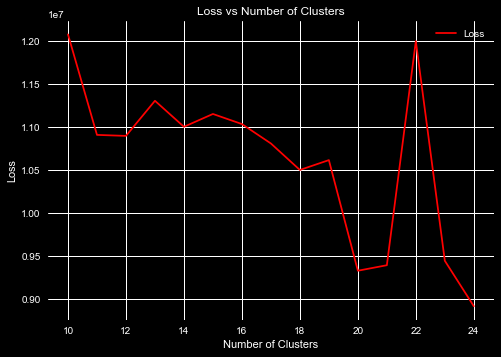

In [235]:
plt.plot(np.linspace(10, 24, len(losses)), losses, color='red', label='Loss')
plt.xlabel('Number of Clusters')
plt.ylabel('Loss')
plt.title('Loss vs Number of Clusters')
plt.legend()
plt.savefig('plots/loss_vs_number_of_clusters.png')
plt.show()

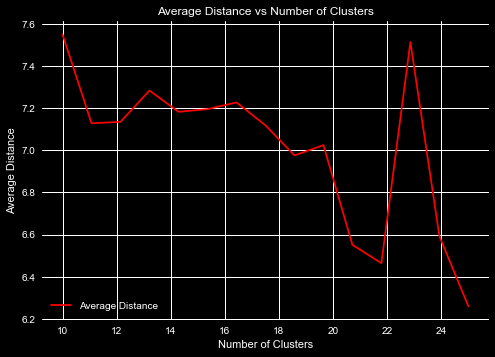

In [236]:
plt.plot(np.linspace(10, 25, len(avgDist)), avgDist,
         color='red', label='Average Distance')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Distance')
plt.title('Average Distance vs Number of Clusters')
plt.legend()
plt.savefig('plots/avg_distance_vs_number_of_clusters.png')
plt.show()


In the above graphs, we can see that we are getting somewhat of a deviation from the expected elbow curve. This is because since the distribution of initial median points is random, it is not necessary that when the model converges, it has the desired number of clusters. It very well might be that the number of clusters obtained by the algorithm are less than the mentioned ones. When this is the scenario, the average distance and the loss might become greater than the previous iterations where the number of clusters were more than the mentioned ones. The avg distance graph is ever decreasing as since the number of clusters are increasing, the average distance is also decreasing. Moreover we are performing k-medians instead of k-means due to which the elbow itself would not be as smooth as it would have been had we been performing k-means.

Looking at the above 2 graphs, I selected the number of clusters to be 24.

### 4.3 Applying K-median with the selected number of custers

In [237]:
dataPts = pd.DataFrame(dataPts, columns=pcaCols)

In [238]:
initCenter = []
# randomly assigning points as initial medians
for i in range(24):
    initCenter.append(dataPts.sample(n=1, random_state=10*i).iloc[0])
kmed = kmedians(data=dataPts, number_clusters=24,
                initial_medians=initCenter)
kmed.process()
medians = kmedians.get_medians(kmed)
clusters = kmedians.get_clusters(kmed)

# 5. Handling more_than_50k.csv file

## 1. Preprocessing

In [239]:
# getting basic information about the data
moreThan50k.head()

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AHSCOL,AMARITL,AMJIND,AMJOCC,...,PARENT,PEFNTVTY,PEMNTVTY,PENATVTY,PRCITSHP,SEOTR,VETQVA,VETYN,WKSWORK,YEAR
0,57,Self-employed-incorporated,11,2,High school graduate,0,Not in universe,Married-civilian spouse present,Manufacturing-durable goods,Executive admin and managerial,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95
1,44,Private,3,38,High school graduate,0,Not in universe,Married-civilian spouse present,Mining,Transportation and material moving,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,No,1,48,94
2,54,Private,19,26,High school graduate,1550,Not in universe,Married-civilian spouse present,Manufacturing-nondurable goods,Adm support including clerical,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94
3,25,Private,33,2,9th grade,0,Not in universe,Never married,Retail trade,Executive admin and managerial,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,1,Not in universe,2,52,95
4,26,Private,11,5,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,Manufacturing-durable goods,Professional specialty,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95


In [240]:
moreThan50k.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3580 entries, 0 to 3579
Data columns (total 40 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   AAGE      3580 non-null   int64 
 1   ACLSWKR   3580 non-null   object
 2   ADTIND    3580 non-null   int64 
 3   ADTOCC    3580 non-null   int64 
 4   AHGA      3580 non-null   object
 5   AHRSPAY   3580 non-null   int64 
 6   AHSCOL    3580 non-null   object
 7   AMARITL   3580 non-null   object
 8   AMJIND    3580 non-null   object
 9   AMJOCC    3580 non-null   object
 10  ARACE     3580 non-null   object
 11  AREORGN   3580 non-null   object
 12  ASEX      3580 non-null   object
 13  AUNMEM    3580 non-null   object
 14  AUNTYPE   3580 non-null   object
 15  AWKSTAT   3580 non-null   object
 16  CAPGAIN   3580 non-null   int64 
 17  CAPLOSS   3580 non-null   int64 
 18  DIVVAL    3580 non-null   int64 
 19  FILESTAT  3580 non-null   object
 20  GRINREG   3580 non-null   object
 21  GRINST    3580

In [241]:
moreThan50k.describe()


,AAGE,ADTIND,ADTOCC,AHRSPAY,CAPGAIN,CAPLOSS,DIVVAL,NOEMP,SEOTR,VETYN,WKSWORK,YEAR
count,3580.000000,3580.000000,3580.000000,3580.000000,3580.000000,3580.000000,3580.000000,3580.000000,3580.000000,3580.000000,3580.000000,3580.000000
mean,46.051397,29.218994,11.978492,75.000838,4626.358939,192.334358,1629.039665,4.027095,0.260894,1.982402,47.814246,94.532402
std,11.858490,15.440051,11.982703,407.656986,16403.578911,606.889082,7177.324140,2.116895,0.637456,0.131503,12.548865,0.499019
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,94.000000
25%,37.000000,16.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,52.000000,94.000000
50%,45.000000,33.000000,8.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,2.000000,52.000000,95.000000
75%,53.000000,42.000000,17.000000,0.000000,0.000000,0.000000,400.000000,6.000000,0.000000,2.000000,52.000000,95.000000
max,90.000000,51.000000,46.000000,8000.000000,99999.000000,3004.000000,99999.000000,6.000000,2.000000,2.000000,52.000000,95.000000


### Replacing missing data with NaN

In [242]:
# stripping for leading and trailing spaces
for i in moreThan50k.columns:
    if moreThan50k[i].dtype != 'int64':
        moreThan50k[i] = moreThan50k[i].str.strip()

In [243]:
# replacing the ? vals with nan vals
moreThan50k = moreThan50k.replace('?', np.NaN)

### Removing columns where more than 40 % of the values are missing

In [244]:
# looking at the data with more than 40% missing values
columns50k = []
percentageOfNan50k = []
colsToRemove50k = []
for i in moreThan50k.columns:
    columns50k.append(i)
    percentageOfNan50k.append(
        moreThan50k[i].isnull().sum()*100/moreThan50k.shape[0])
    if percentageOfNan50k[-1] > 40:
        colsToRemove50k.append(i)

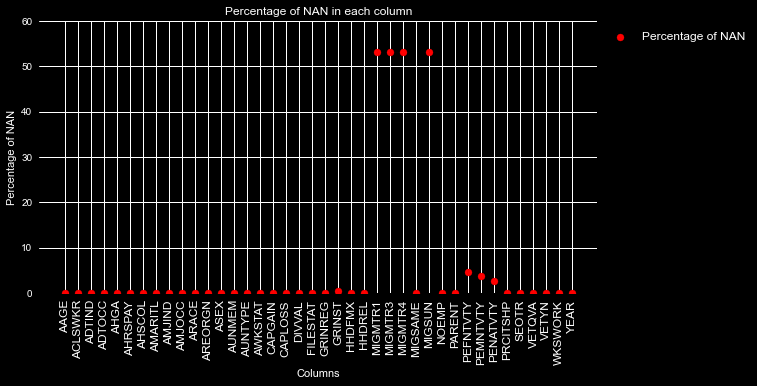

In [245]:
# visualising the columns which have more than 40% nan values
plt.figure(figsize=(10, 5))
plt.scatter(columns50k, percentageOfNan50k, color='red',
            marker='o', label='Percentage of NAN')
plt.xticks(rotation=90, fontsize=12)
plt.ylim(0, 60, 10)
plt.xlabel('Columns')
plt.ylabel('Percentage of NAN')
plt.title('Percentage of NAN in each column')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
plt.savefig('plots/percentage_of_nan_50k.png')
plt.show()


In [246]:
# removing the columns which were removed at this stage in the complete data
preprocessedMoreThan50k = moreThan50k.drop(colsToRemove, axis=1)

## Feature Analysis

### Histogram of values of each feature

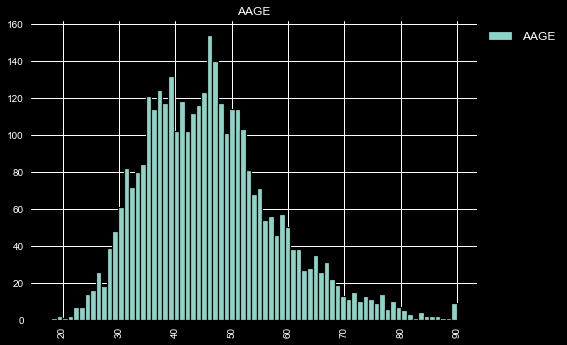

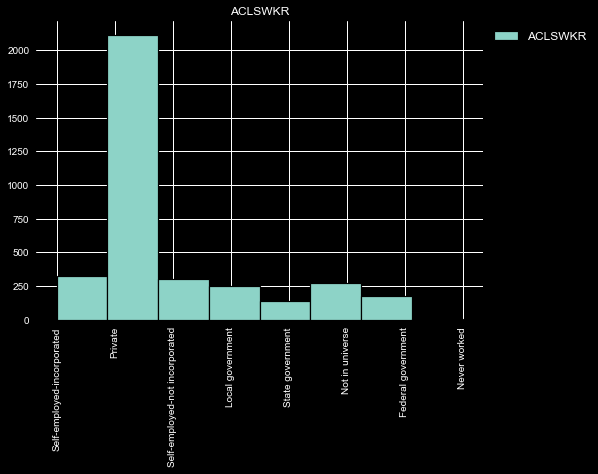

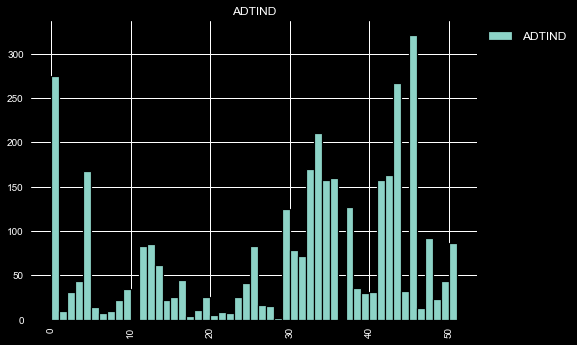

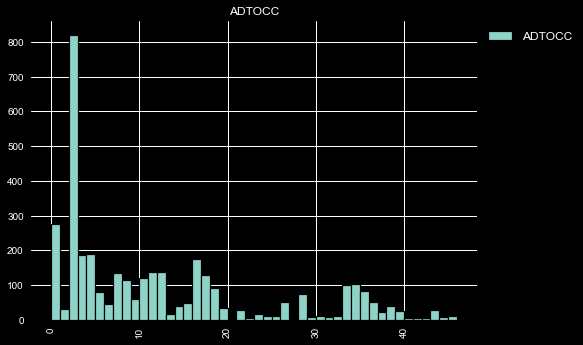

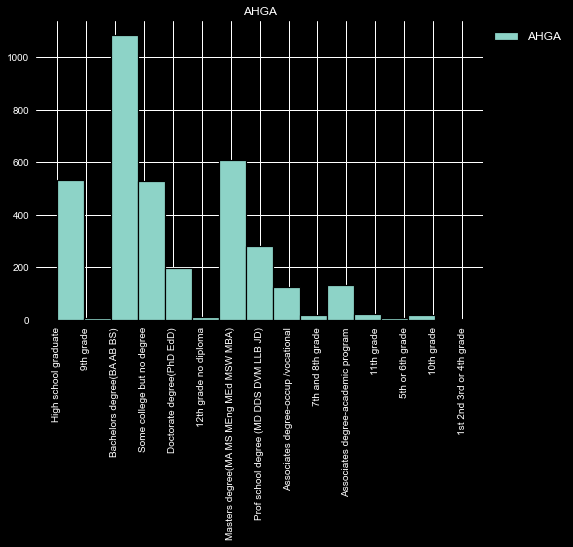

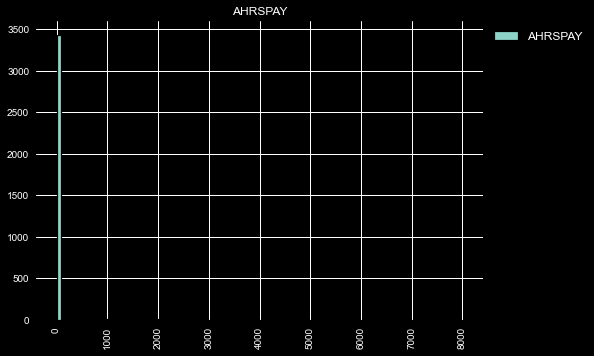

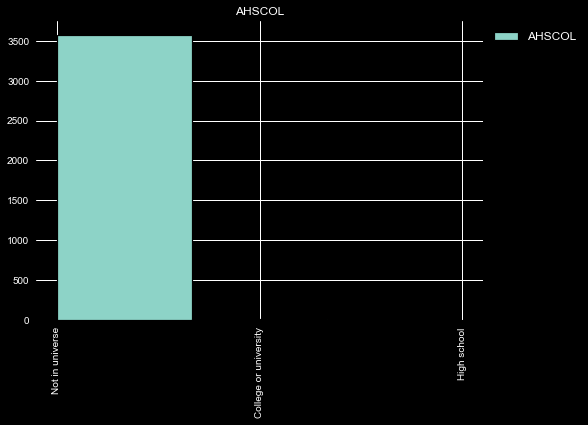

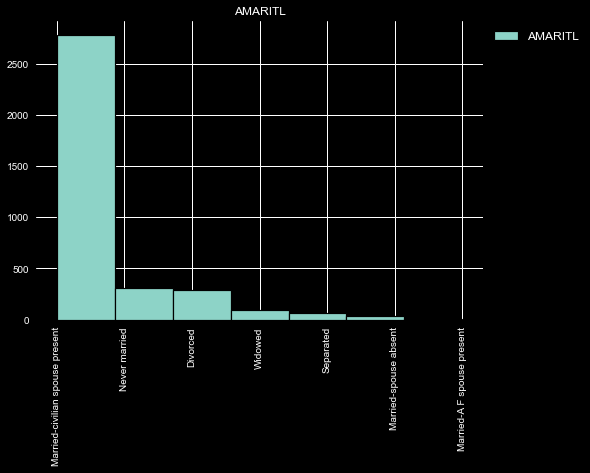

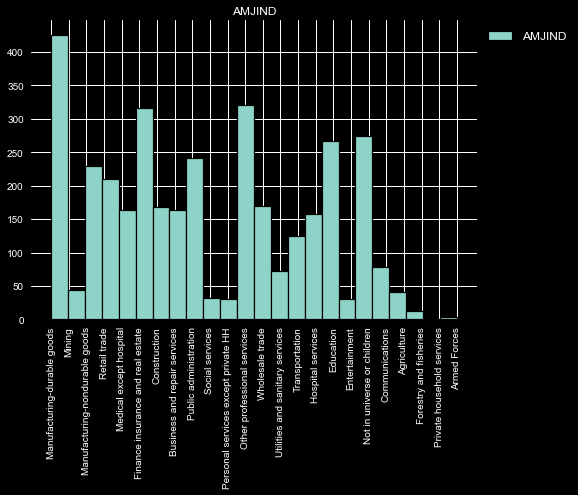

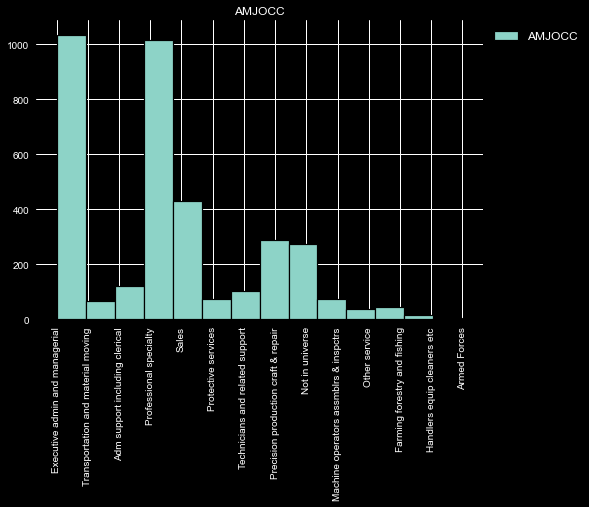

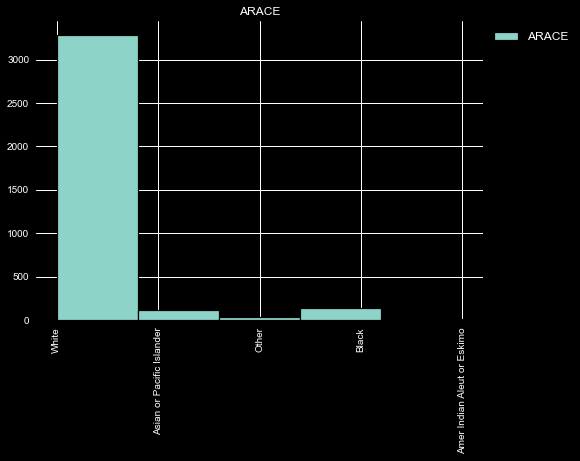

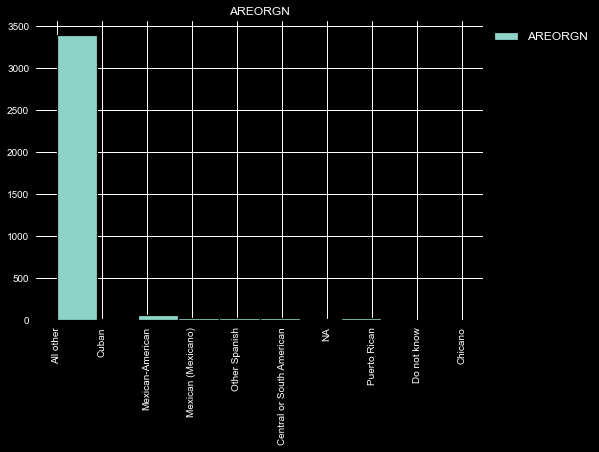

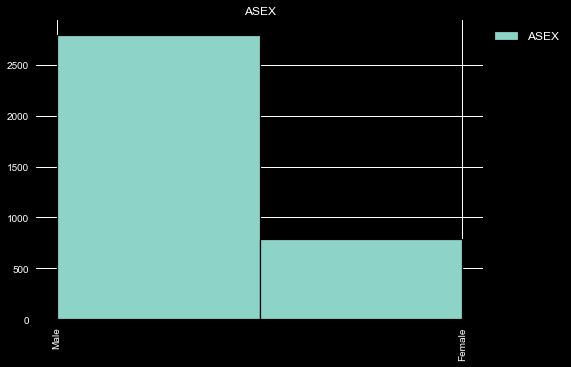

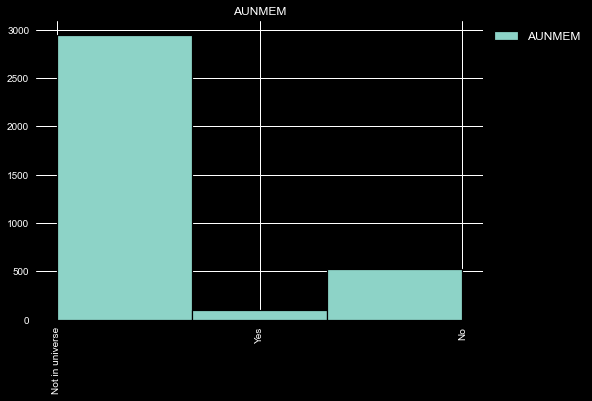

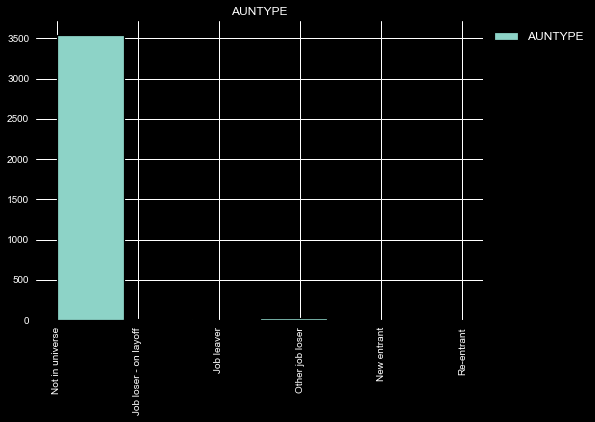

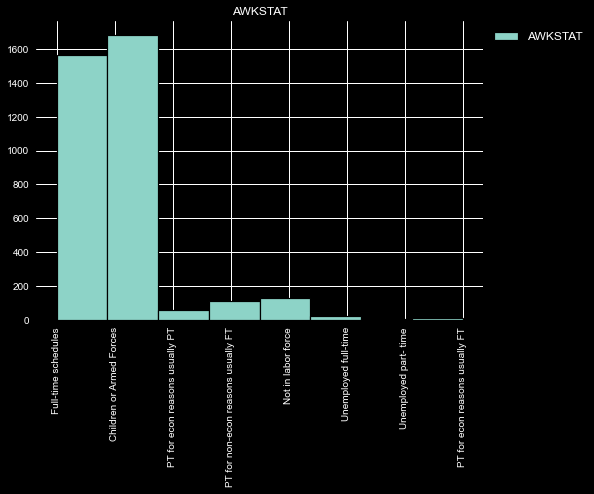

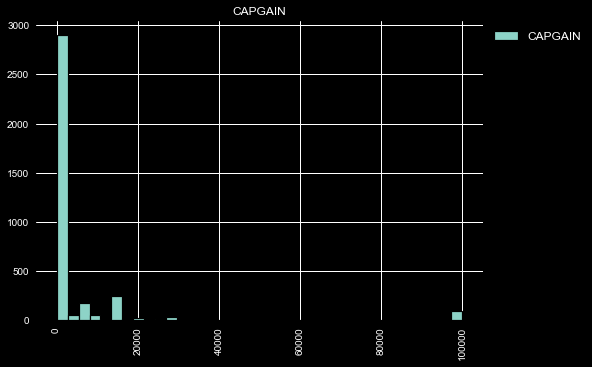

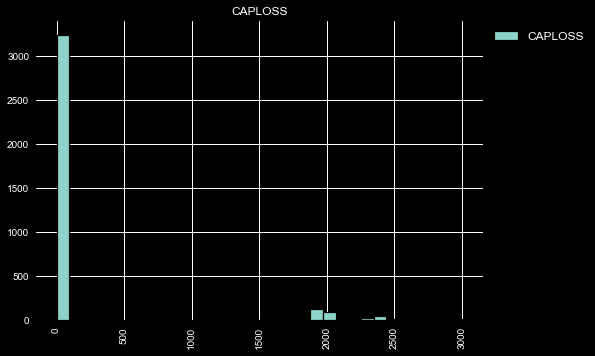

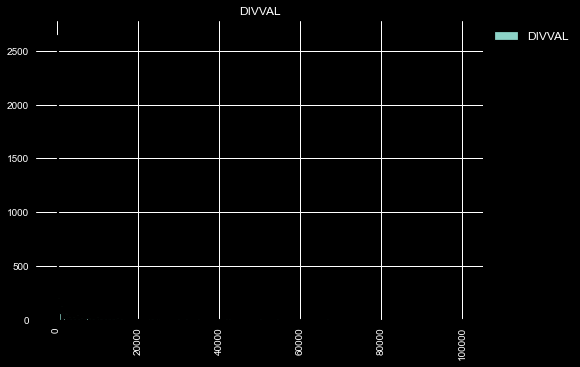

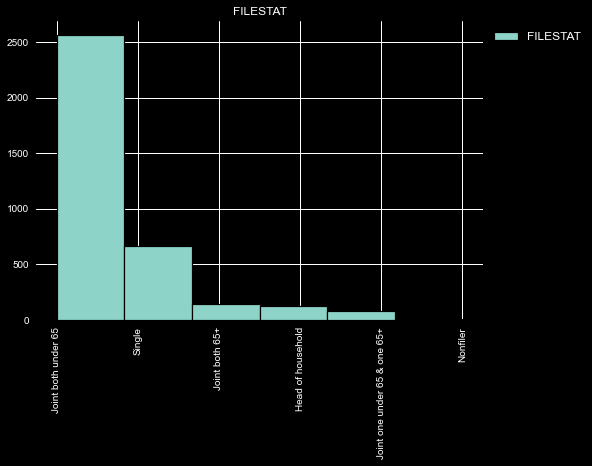

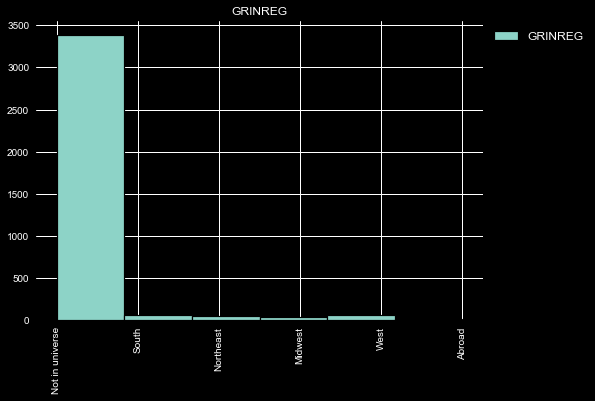

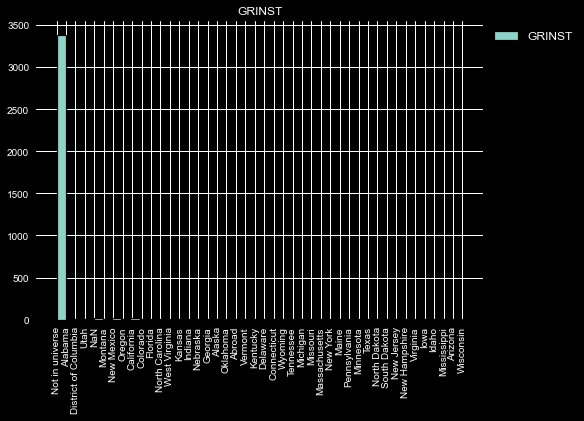

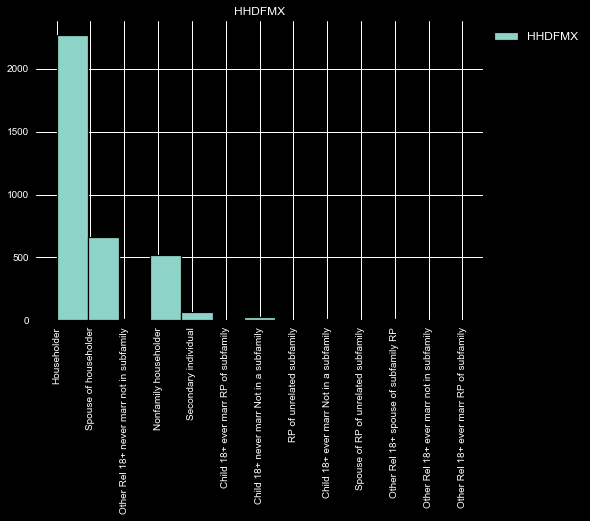

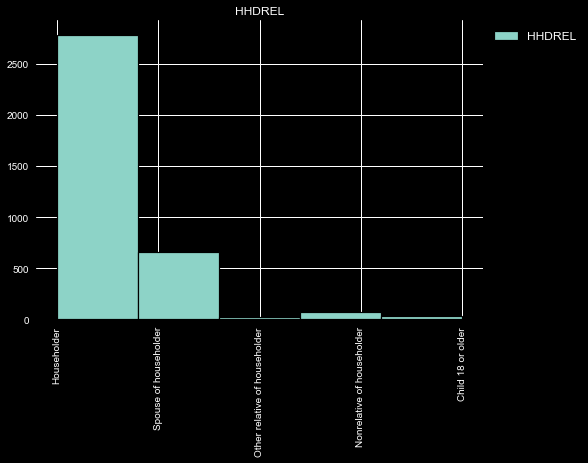

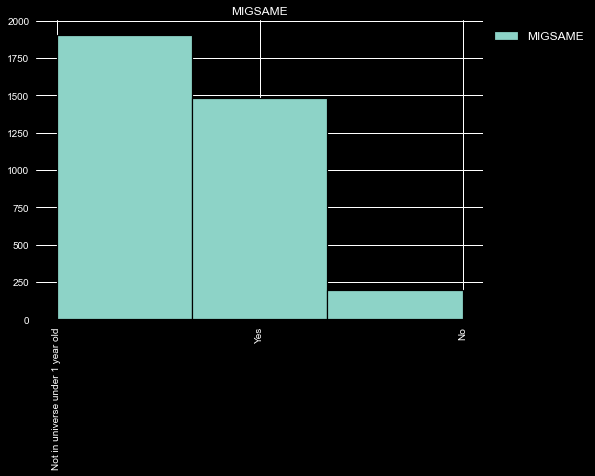

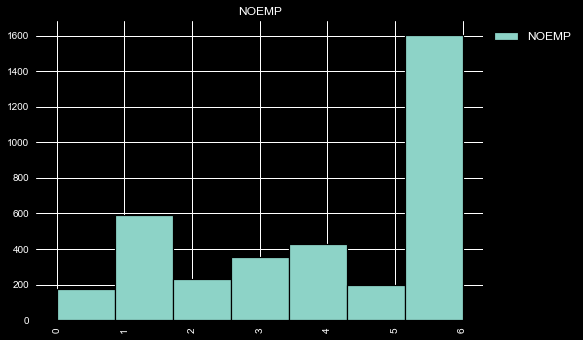

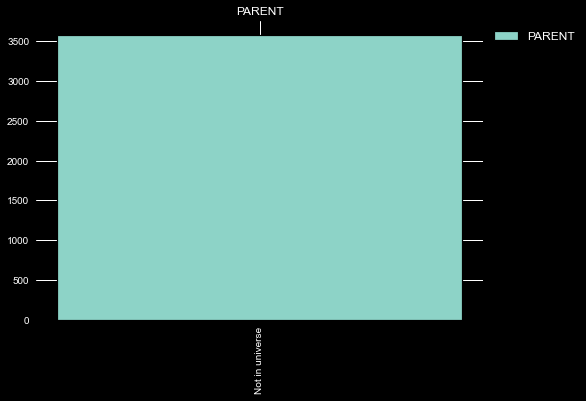

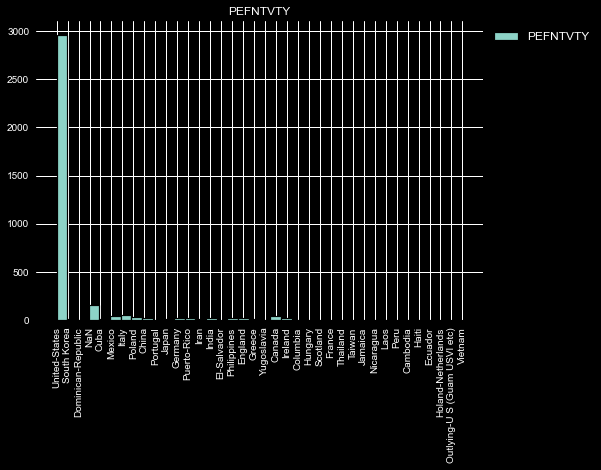

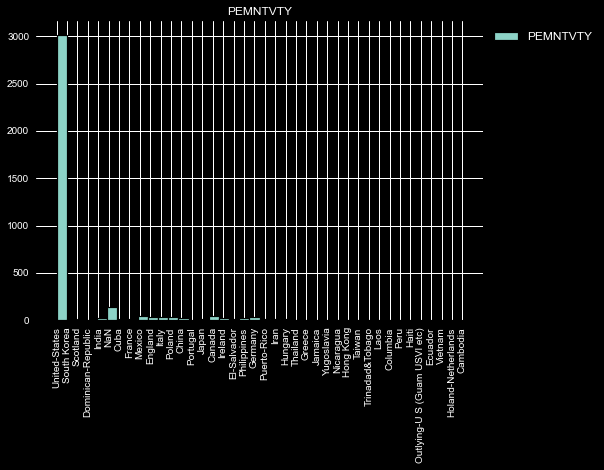

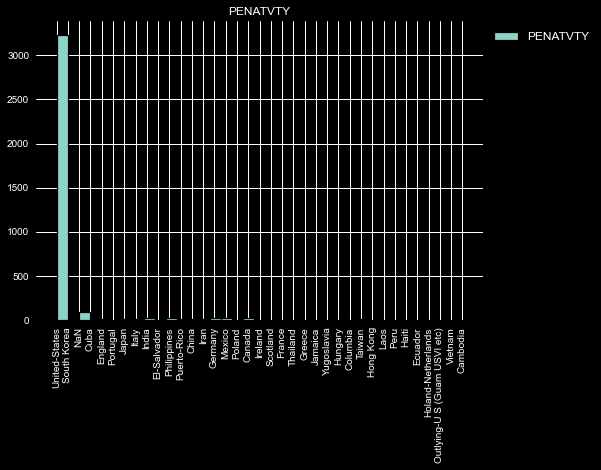

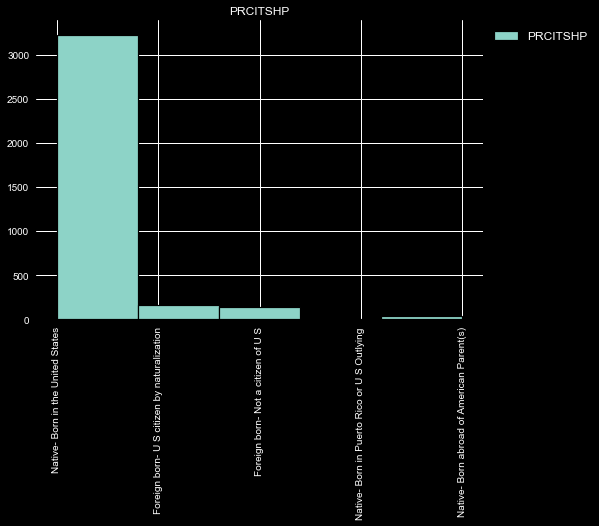

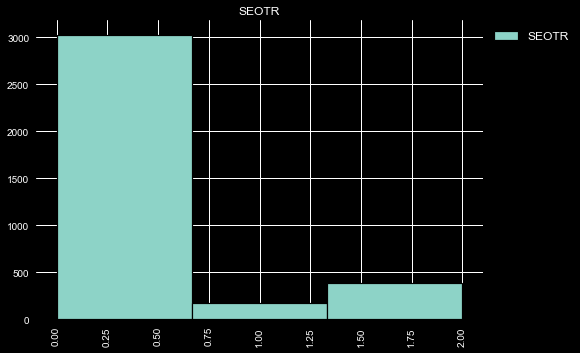

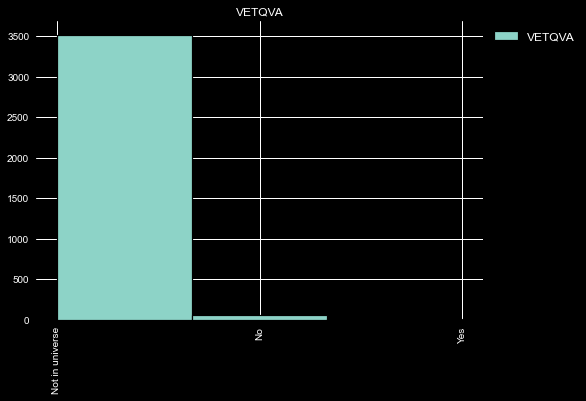

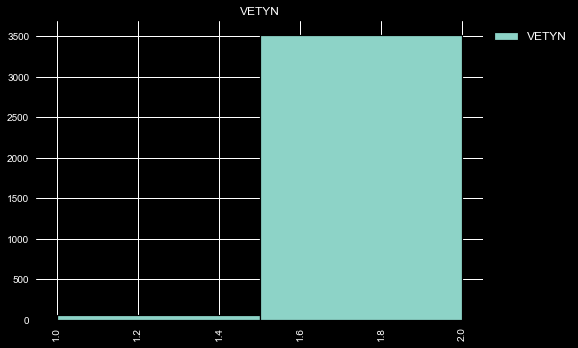

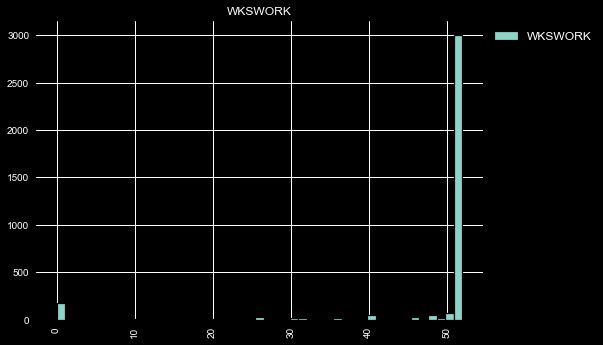

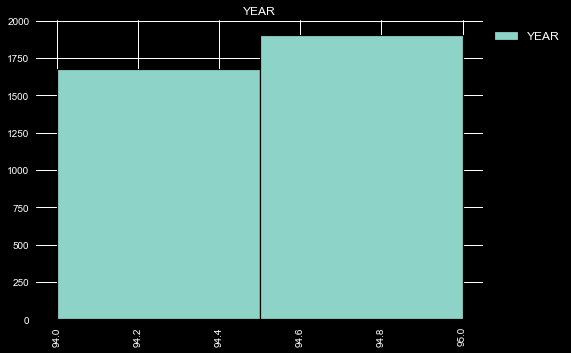

In [247]:
# code to plot the histograms of each feature of the dataset
for j in range(len(preprocessedMoreThan50k.columns)):
    i = preprocessedMoreThan50k.columns[j]
    plt.hist(preprocessedMoreThan50k[i].replace(np.NaN, 'NaN'), bins=len(
        preprocessedMoreThan50k[i].unique()), label=i, edgecolor='black', linewidth=1.2, histtype='barstacked')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
    plt.xticks(rotation=90, fontsize=10)
    plt.title(i)
    plt.savefig('plots/histogram_populationData50k_'+i+'.png')
    plt.show()

### Removing the columns where one value dominates over other

In [248]:
# dropping the imbalanced columns as obtained in the original dataset
preprocessedMoreThan50k.drop(imbalancedCols, axis=1, inplace=True)

## Imputation, Bucketization and One Hot Encoding

### Replacing missing data with mode

In [249]:
# replacing the missing data from the mode obtained from the original population dataset
for i in preprocessedMoreThan50k.columns:
    preprocessedMoreThan50k[i] = preprocessedMoreThan50k[i].replace(np.NaN, globalModeDict[i])

### Bucketization of the data

In [250]:
# Bucketizing the data using the buckets obtained from the original population dataset
for i in preprocessedMoreThan50k.columns:
    if preprocessedMoreThan50k[i].dtype == 'int64' and len(preprocessedMoreThan50k[i].unique()) > 6:
        finalbins = finalBuckets[i]
        finalLabels = []
        for j in range(0, len(finalbins)-1):
            finalLabels.append(
                str(int(finalbins[j])) + '-' + str(int(finalbins[j+1])))
        preprocessedMoreThan50k[i] = pd.cut(
            preprocessedMoreThan50k[i], bins=finalbins, labels=finalLabels)

### One Hot Encoding All the Features

In [251]:
# Dataframe to store the data after one hot encoding
finalPopulationData50k = pd.DataFrame()

In [252]:
# One hot encoding the data
for itr in (range(len(preprocessedMoreThan50k.columns))):
    i = preprocessedMoreThan50k.columns[itr]
    ohtVector = pd.get_dummies(
        preprocessedMoreThan50k[i], sparse=True, drop_first=False)
    for j in ohtVector.columns:
        finalPopulationData50k[str(i) + '_' + str(j)] = ohtVector[j]

Currently we have 135 columns as opposed to 172 that we should have. This is because there might have been some columns which had some entries int the original population.csv file which were not present in the more_than_50k.csv file. This lead to them being dropped. For further steps we need those columns so we would be adding those columns with all values assigned to 0.

In [253]:
# adding the missing columns to the final dataframe
for i in finalPopulationData.columns:
    if i not in finalPopulationData50k.columns:
        finalPopulationData50k[i] = 0

Now we have the desired 172 columns.

### Feature Transformation

In [254]:
tempArr = finalPopulationData50k.values

In [255]:
tempArr.shape

(3580, 172)

In [256]:
# Transforming the earlier trained PCA model on the more than 50k population data
tempDf50k = model.transform(tempArr)

In [257]:
tempDf50k.shape

(3580, 35)

In [258]:
# creating the final dataframe with the transformed data and columns
finalData50k = pd.DataFrame(tempDf50k, columns=pcaCols)

In [259]:
# normalising the data with respect to the original population data
dataPts50k = ss.transform(finalData50k)

# 6. Comparing more than 50k data with the original population data

In [260]:
# list containing the cluster distribution of the population data
clusterPop = []
titles = []
for i in clusters:
    clusterPop.append(len(i))
    titles.append('Cluster' + str(len(titles) + 1))

In [261]:
# getting prediction for the more than 50k population data on the clusters obtained
preds = kmed.predict(dataPts50k)


In [262]:
# getting the cluster distribution for the more than 50k population data
predClusters = [0 for i in range(len(titles))]
for i in preds:
    predClusters[i] += 1

### 6.1 Comparing the proportion of data in each cluster for the more_than_50k data to the proportion of data in each cluster for the general population

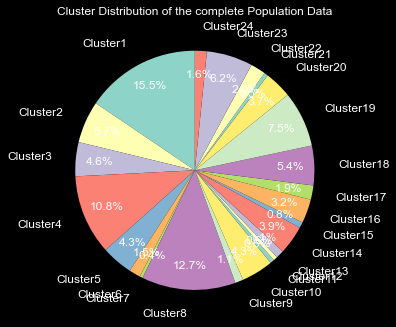

In [263]:
plt.pie(clusterPop, labels=titles, autopct='%1.1f%%', startangle=90, pctdistance=0.8, labeldistance=1.2, textprops={'fontsize': 12})
plt.title('Cluster Distribution of the complete Population Data')
plt.savefig('plots/cluster_distribution_completePopulationData.png')
plt.show()

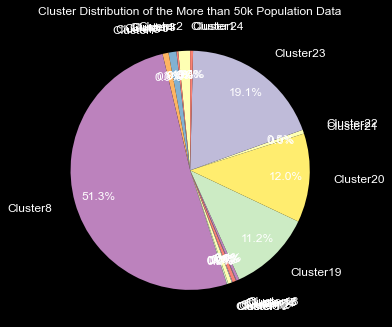

In [264]:
plt.pie(predClusters, labels=titles, autopct='%1.1f%%', startangle=90, pctdistance=0.8, labeldistance=1.2, textprops={'fontsize': 12})
plt.title('Cluster Distribution of the More than 50k Population Data')
plt.savefig('plots/cluster_distribution_moreThan50kPopulationData.png')
plt.show()

In [265]:
# getting the percentage wise distribution of clusters for both the datasets
percentageInEachClusterPop = []
for i in range(len(clusterPop)):
    percentageInEachClusterPop.append(clusterPop[i]*100/preprocessedPopulation.shape[0])
percentageInEachClusterPop50k = []
for i in range(len(predClusters)):
    percentageInEachClusterPop50k.append(predClusters[i]*100/preprocessedMoreThan50k.shape[0])

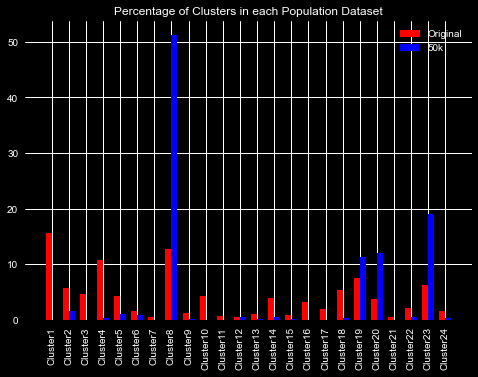

In [266]:
x = np.arange(len(clusters))
width = .35
plt.bar(x-width/2, percentageInEachClusterPop,
        width, label='Original', color='red')
plt.bar(x+width/2, percentageInEachClusterPop50k,
        width, label='50k', color='blue')
plt.xticks(x, titles, rotation=90)
plt.legend()
plt.title('Percentage of Clusters in each Population Dataset')
plt.savefig('plots/percentage_of_clusters_in_each_dataset.png')
plt.show()

In [267]:
numsInEachClusterPop = []
for i in range(len(clusterPop)):
    numsInEachClusterPop.append(clusterPop[i])
numsInEachClusterPop50k = []
for i in range(len(predClusters)):
    numsInEachClusterPop50k.append(predClusters[i])

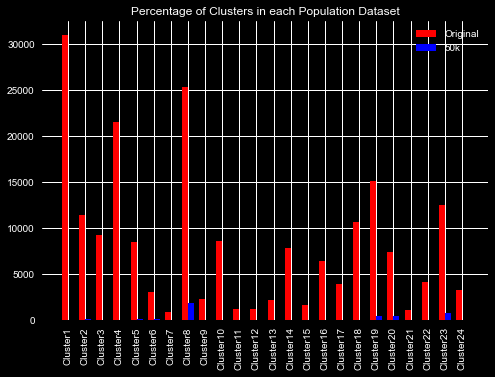

In [268]:
x = np.arange(len(clusters))
width = .35
plt.bar(x-width/2, numsInEachClusterPop,
        width, label='Original', color='red')
plt.bar(x+width/2, numsInEachClusterPop50k,
        width, label='50k', color='blue')
plt.xticks(x, titles, rotation=90)
plt.legend()
plt.title('Percentage of Clusters in each Population Dataset')
plt.savefig('plots/percentage_of_clusters_in_each_dataset.png')
plt.show()

It would not be fair to compare the number of points in each cluster as the difference between the two is very large, as a result each cluster in the original population data has a lot of points as compared to the more_than_50k data. To counter this problem, I have compared the percentage of points in each cluster. Along with that I have also created double bar graphs and pie charts to show the proportion of data in each cluster.

From that, it is evident that clusters 8 and 23, are over represented with more_than_50k data, while clusters like 1 and 4 are over represented with the general population data.

Analysing the component having maximum variance in PCA

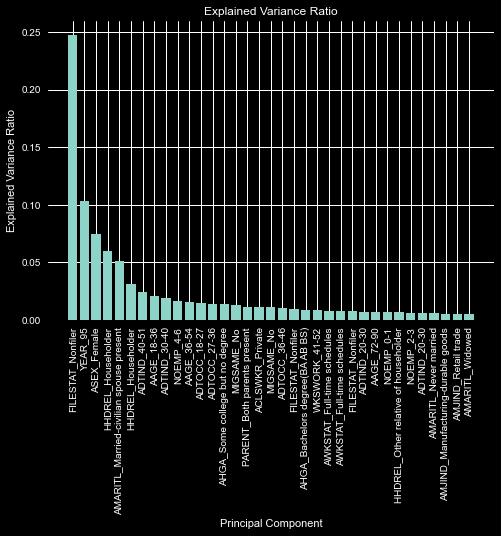

In [269]:
plt.bar(range(len(pcaCols)), model.explained_variance_ratio_)
plt.xticks(range(len(pcaCols)), pcaCols, rotation=90)
plt.title('Explained Variance Ratio')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.show()

Getting the inverted population data

In [270]:
invertedPopulationData = model.inverse_transform(finalData)

In [281]:
invertedPopulationData.shape

(199523, 172)

In [282]:
# converting to pandas dataframe
invertedPopulationData = pd.DataFrame(
    invertedPopulationData, columns=finalPopulationData50k.columns)

In [283]:
#looking at the value counts of the most important feature
invertedPopulationData.FILESTAT_Nonfiler.value_counts()

-0.020864    7764
 0.031599    7498
-0.030366    6703
 0.022098    6393
-0.018182    2094
             ... 
 0.034262       1
 0.012844       1
-0.226689       1
 0.668960       1
 0.034552       1
Name: FILESTAT_Nonfiler, Length: 86919, dtype: int64

In [312]:
# binning the value counts to properly visualize and interpret the data
finalbins = np.linspace(
    invertedPopulationData['FILESTAT_Nonfiler'].min(), invertedPopulationData['FILESTAT_Nonfiler'].max(), 20)
temp = pd.cut(invertedPopulationData['FILESTAT_Nonfiler'], 20)

In [313]:
# sorting the index values of inverted value dataframe and making a bar graph
vals = temp.value_counts().sort_index()
barLabels = vals.index.tolist()
finalBarLabels = [str(i) for i in barLabels]

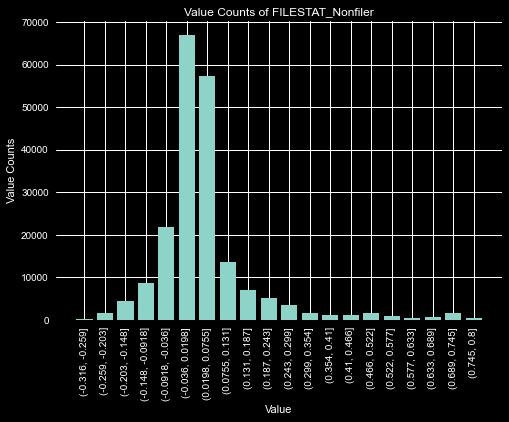

In [314]:
plt.bar(range(len(vals)), vals)
plt.xticks(range(len(finalBarLabels)), finalBarLabels, rotation=90)
plt.title('Value Counts of FILESTAT_Nonfiler')
plt.ylabel('Value Counts')
plt.xlabel('Value')
plt.savefig('plots/value_counts_of_FILESTAT_Nonfiler.png')
plt.show()

In [315]:
# creating a dataframe to study the FILESTAT_Nonfiler property of the medians obtained
centroids = pd.DataFrame(medians)

In [316]:
centroids.shape

(24, 35)

In [317]:
# inverse transforming the centroids to get the original values
centroids = model.inverse_transform(centroids)

In [318]:
centroids.shape

(24, 172)

In [319]:
centroids = pd.DataFrame(centroids, columns=finalPopulationData50k.columns)

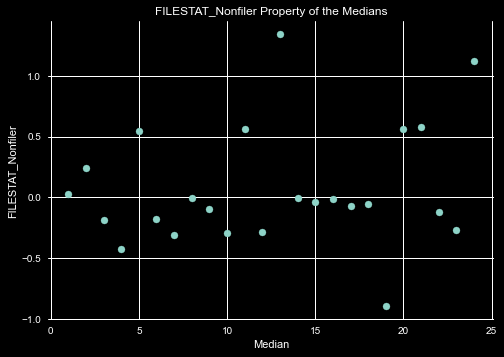

In [320]:
# plotting the FILESTAT_Nonfiler property of the medians obtained
plt.scatter(np.linspace(1, 24, len(centroids['FILESTAT_Nonfiler'])), centroids['FILESTAT_Nonfiler'])
plt.title('FILESTAT_Nonfiler Property of the Medians')
plt.xlabel('Median')
plt.ylabel('FILESTAT_Nonfiler')
plt.savefig('plots/FILESTAT_Nonfiler_property_of_medians.png')
plt.show()

In [321]:
# Creating the inverted graph for the greater than 50k data too
invertedPopulationData50k = model.inverse_transform(finalData50k)
temp = pd.cut(invertedPopulationData['FILESTAT_Nonfiler'], bins=finalbins)

In [322]:
# sorting the index values of inverted value dataframe and making a bar graph
vals = temp.value_counts().sort_index()
barLabels = vals.index.tolist()
finalBarLabels = [str(i) for i in barLabels]

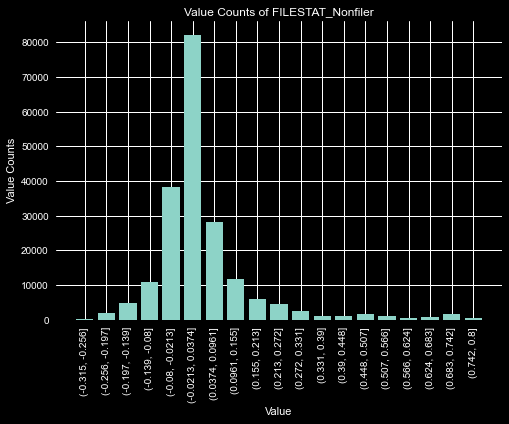

In [323]:
plt.bar(range(len(vals)), vals)
plt.xticks(range(len(finalBarLabels)), finalBarLabels, rotation=90)
plt.title('Value Counts of FILESTAT_Nonfiler')
plt.ylabel('Value Counts')
plt.xlabel('Value')
plt.savefig('plots/value_counts_of_FILESTAT_Nonfiler_greaterThan50k.png')
plt.show()

From the graphs it is evident that the majority of the general population data has the value of FILESTAT_Nonfiler between -0.0918 to 0.0755. From the scatter plot, one can see that the the clusters like 1, 8 and so on have their FILESTAT_Nonfiler have values which lie in the above range.

From the graphs, it is evident that the majority of the greater than 50k data has the value of FILESTAT_Nonfiler between -0.008 to 0.0961. From the scatter plot, one can see that the the clusters like 1, 8 and so on have their FILESTAT_Nonfiler have values which lie in the above range.

From the above graph we were able to deduce which clusters had majority of both the general population and the greater than 50k data. 

A general trend which can be seen for clusters over represented with greater than 50k data like 19, 20 and 23 is that the FILESTAT_Nonfiler value is either very large or very small. However cluster 8 defies this. One of the reasons behind this can be that cluster 8 itself has a lot of points in it from both the general population and the greater than 50k data.

For the clusters being over represented with the general population data, the FILESTAT_Nonfiler value still has some deviation in it but the deviation comparatively smaller than the deviation observed in the clusters over represented with the greater than 50k data. Some of these clusters were 2, 3, 4, 5 and 10

P.S. For the scope of this assignment, all those columns which showed up as int in the pandas dataframe have been considered numeric while the others have been treated as categorical.